# **ViTs para Agave – De Software a Hardware**


### Integrantes del equipo N° #31:
- Arian Yolanda Reyes Aguilar - A01795124
- Oscar Nava Jiménez - A01745524
- Bruno Sánchez García - A01378960

### Asesor del Proyecto: Diego Concepción Villatoro Gerónimo

### Director del Proyecto: Luis Eduardo Falcón Morales
### Proyecto Integrador | Fecha de Entrega: 26/10/2025

### **Propósito de Proyecto**
El proyecto tiene como objetivo implementar y validar un modelo de visión
computacional basado en Vision Transformers (ViTs) para detectar
automáticamente plantas de agave y evaluar su estado de salud mediante
imágenes capturadas en campo. El modelo, desarrollado en PyTorch bajo la
arquitectura bit-STED, ya ha sido probado exitosamente en software. Ahora se
busca llevarlo a una plataforma embebida, específicamente una Raspberry Pi 5,
para evaluar su rendimiento, eficiencia y viabilidad en condiciones reales con
recursos limitados. Esta prueba en hardware permitirá determinar si la solución
es apta para su implementación directa en el entorno agrícola.

### **Contexto sobre Imagenes**

El dataset consta de aproximadamente 2440 imágenes multiespectrales de tamaño 224x224 píxeles, capturadas en cinco campos agrícolas diferentes. Cada imagen está compuesta por múltiples bandas espectrales que incluyen azul (450 nm), verde (560 nm), rojo (650 nm), borde rojo (730 nm) y el infrarrojo cercano (840 nm). Estas imágenes fueron tomadas con drones equipados con sensores especializados, y están destinadas a permitir el análisis detallado de plantas de agave mediante técnicas de visión por computadora. El formato de las imágenes es TIFF multibanda, lo que permite conservar la información espectral necesaria para detectar y evaluar el estado de salud de las plantas.

### **Objetivo de Actividad**

El objetivo de esta actividad es desarrollar, ajustar y evaluar distintos modelos basados en la arquitectura Bit-STED para la detección y clasificación del estado de salud de plantas de agave a partir de imágenes recolectadas en campo. Se entrenarán varias versiones de los modelos con diferentes configuraciones de hiperparámetros, cantidad de bloques y tamaño de red, y se evaluará su desempeño mediante métricas como precisión, exactitud, F1, curvas ROC y análisis de residuos.

Se elaborará una comparación detallada de los modelos considerando tanto la exactitud como el tamaño de los pesos y la complejidad del modelo, aspectos clave para su futura implementación en sistemas con recursos limitados. Finalmente, se seleccionará el modelo que logre el mejor equilibrio entre desempeño y eficiencia, acompañado de gráficos e interpretaciones que respalden su análisis.

Importación de Librerías y Configuración de Rutas

In [2]:
import os
import torch
import torchvision.transforms as T
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tifffile import imread
from PIL import Image, ImageDraw
from model.transformer import TransformerObjectDetection
import utils.counting
import cv2
from pathlib import Path
import random
import time
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from model.transformer import TransformerObjectDetection
import torch.optim as optim
import math, glob, pathlib
from model.trainer import trainer

In [3]:
def leer_etiquetas_yolo(path_txt, img_ancho, img_alto):
    """
    Lee un archivo de etiquetas en formato YOLO y devuelve las cajas en 
    coordenadas absolutas escaladas al tamaño del modelo (por defecto 224x224).
    El formato YOLO esperado por línea es: class_id x_center y_center width height
    Donde las coordenadas están normalizadas en el rango [0, 1].
    """
    cajas = []
    # Abrir y leer el archivo línea por línea
    with open(path_txt, "r") as f:
        for linea in f:
            partes = linea.strip().split()
            if len(partes) == 5:
                # Desempaquetar: clase, centro (x, y) y tamaño (w, h)
                _, x_center, y_center, w, h = map(float, partes)

                # Convertir de normalizado (0–1) a absoluto (px)
                x_center_abs = x_center * img_ancho
                y_center_abs = y_center * img_alto
                w_abs = w * img_ancho
                h_abs = h * img_alto

                # Calcular esquinas (x1, y1, x2, y2)
                x1 = x_center_abs - w_abs / 2
                y1 = y_center_abs - h_abs / 2
                x2 = x_center_abs + w_abs / 2
                y2 = y_center_abs + h_abs / 2

                cajas.append([x1, y1, x2, y2])

    # Escalar a tamaño de entrada del modelo (224x224)
    modelo_ancho, modelo_alto = 224, 224
    cajas_escaladas = [
        [
            x1 * modelo_ancho / img_ancho,
            y1 * modelo_alto / img_alto,
            x2 * modelo_ancho / img_ancho,
            y2 * modelo_alto / img_alto
        ]
        for (x1, y1, x2, y2) in cajas
    ]

    return cajas_escaladas

In [ ]:
def convertir_circulos_a_cajas(circulos):
    """
    Convierte una lista de círculos en cajas delimitadoras (bounding boxes)
    en formato [x1, y1, x2, y2].
    Cada círculo se representa por su centro (xc, yc) y su radio (r).  
    La conversión genera una caja cuadrada que encierra completamente el círculo.
    """
    # Cada círculo (xc, yc, r) se convierte en caja:
    #   x1 = xc - r → esquina superior izquierda (x)
    #   y1 = yc - r → esquina superior izquierda (y)
    #   x2 = xc + r → esquina inferior derecha (x)
    #   y2 = yc + r → esquina inferior derecha (y)
    return [[xc - r, yc - r, xc + r, yc + r] for (xc, yc, r) in circulos]


In [ ]:
def calcular_iou(cajaA, cajaB):
    """
    Calcula la Intersección sobre Unión (IoU, *Intersection over Union*)
    entre dos cajas delimitadoras.
    La IoU mide cuánto se solapan dos cajas de detección, dividiendo el
    área de su intersección entre el área total (unión) de ambas.
    """
    # Coordenadas del área de intersección (rectángulo común)
    xA = max(cajaA[0], cajaB[0])  # Punto superior izquierdo (x)
    yA = max(cajaA[1], cajaB[1])  # Punto superior izquierdo (y)
    xB = min(cajaA[2], cajaB[2])  # Punto inferior derecho (x)
    yB = min(cajaA[3], cajaB[3])  # Punto inferior derecho (y)

    # Calcular área de intersección (ancho × alto)
    inter = max(0, xB - xA) * max(0, yB - yA)

    # Calcular áreas individuales de cada caja
    areaA = (cajaA[2] - cajaA[0]) * (cajaA[3] - cajaA[1])
    areaB = (cajaB[2] - cajaB[0]) * (cajaB[3] - cajaB[1])

    # Calcular área de la unión
    union = areaA + areaB - inter

    # IoU = intersección / unión (1e-6 evita división por cero)
    return inter / (union + 1e-6)


In [ ]:
def calcular_metricas(gt_cajas, pred_cajas, iou_umbral=0.5):
    """
    Calcula las métricas de detección: Precisión, Recall y F1-score
    basadas en la coincidencia entre las cajas de verdad de terreno (GT)
    y las predicciones del modelo, utilizando un umbral de IoU.
    """
    # Contador de verdaderos positivos
    TP = 0

    # Conjuntos para registrar coincidencias (evita doble conteo)
    gt_usadas = set()
    pred_usadas = set()

    # Comparar cada caja GT con las predicciones
    for i, gt in enumerate(gt_cajas):
        for j, pred in enumerate(pred_cajas):

            # Saltar si la predicción ya fue emparejada
            if j in pred_usadas:
                continue

            # Calcular IoU entre caja GT y predicha
            if calcular_iou(gt, pred) >= iou_umbral:
                TP += 1
                gt_usadas.add(i)
                pred_usadas.add(j)
                break  # Solo se empareja una predicción por GT

    # Cálculo de métricas
    FP = len(pred_cajas) - len(pred_usadas)  # Falsos positivos
    FN = len(gt_cajas) - len(gt_usadas)      # Falsos negativos

    # Precisión: proporción de detecciones correctas sobre todas las predicciones
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Recall: proporción de detecciones correctas sobre las cajas reales
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1-score: media armónica entre precisión y recall
    f1 = (
        2 * precision * recall / (precision + recall)
        if (precision + recall) > 0 else 0
    )
    return precision, recall, f1

In [ ]:
def dibujar_resultados(img, gt_cajas, pred_cajas, titulo="Resultados", ax=None):
    """
    Dibuja las cajas Ground Truth (verde) y Predichas (rojo) sobre una imagen PNG.
    Compatible con el formato de imágenes usado por YOLO (uint8, 3 canales).
    """
    # Crear eje si no se proporciona
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Convertir BGR → RGB si la imagen proviene de OpenCV
    if img.ndim == 3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = np.stack([img] * 3, axis=-1) if img.ndim == 2 else img

    # Mostrar imagen
    ax.imshow(img_rgb)
    ax.set_title(titulo)
    ax.axis("off")

    # Dibujar cajas Ground Truth (verde)
    for (x1, y1, x2, y2) in gt_cajas:
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none', label='Ground Truth'
        )
        ax.add_patch(rect)

    # Dibujar cajas Predichas (rojo punteado)
    for (x1, y1, x2, y2) in pred_cajas:
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Predicción'
        )
        ax.add_patch(rect)

    # Crear leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), loc='upper right', fontsize=8, framealpha=0.6)

    if ax is None:
        plt.tight_layout()
        plt.show()
    return None

In [ ]:
# Directorios de imágenes y etiquetas
IMAGES_DIR = Path("Zones_cbbox_dataset_10/val/images")
LABELS_DIR = Path("Zones_cbbox_dataset_10/val/labels_yolo")

# Buscar todos los archivos .png y .txt
imagenes = sorted(IMAGES_DIR.glob("*.png"))
etiquetas = sorted(LABELS_DIR.glob("*.txt"))

# Mostrar conteo de archivos
print(f"Total de imágenes PNG: {len(imagenes)}")
print(f"Total de etiquetas TXT: {len(etiquetas)}")

# Seleccionar y Procesar cada imagen seleccionada aleatorias (total 6 imágenes)
if len(imagenes) < 6:
    raise ValueError("No hay suficientes imágenes en el directorio (se requieren al menos 6).")

imagenes_seleccionadas = random.sample(imagenes, 6)

for ruta_imagen in imagenes_seleccionadas:
    nombre_imagen = ruta_imagen.name
    ruta_etiqueta = LABELS_DIR / (Path(nombre_imagen).stem + '.txt')
    # Leer imagen como RGB
    imagen = cv2.imread(str(ruta_imagen))
    if imagen is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    # Obtener dimensiones
    alto, ancho = imagen.shape[:2]
    # Convertir a tensor PyTorch [1, 3, H, W]
    imagen_tensor = torch.tensor(imagen, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    # Leer etiquetas en formato YOLO
    gt_cajas = leer_etiquetas_yolo(ruta_etiqueta, ancho, alto)
    # Mostrar resumen
    print(f"Procesada {nombre_imagen} con {len(gt_cajas)} cajas")


Total de imágenes PNG: 1377
Total de etiquetas TXT: 1377
Procesada 0668.png con 6 cajas
Procesada 5306.png con 14 cajas
Procesada 5177.png con 12 cajas
Procesada 0695.png con 5 cajas
Procesada 5153.png con 13 cajas
Procesada 0066.png con 6 cajas


Cargando el Modelo Bit-STED

In [ ]:
def convertir_etiquetas_a_yolo_seguro(base_dir):
    """Convierte etiquetas (xc, yc, r) a formato YOLO (xc, yc, w, h) normalizado.
    Guarda los nuevos archivos en una subcarpeta 'labels_yolo'."""
    labels_dir = Path(base_dir, "labels")
    output_dir = Path(base_dir, "labels_yolo")
    output_dir.mkdir(exist_ok=True)

    archivos = list(labels_dir.glob("*.txt"))
    print(f"Procesando {len(archivos)} archivos en {labels_dir}...")

    for txt_path in archivos:
        with open(txt_path, "r") as f:
            lineas = f.readlines()

        nuevas_lineas = []
        for linea in lineas:
            partes = linea.strip().split()
            if len(partes) == 4:
                clase, xc, yc, r = map(float, partes)
                w = h = r * 2
                nuevas_lineas.append(f"{int(clase)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

        nuevo_path = output_dir / txt_path.name
        with open(nuevo_path, "w") as f:
            f.writelines(nuevas_lineas)

    print(f"Conversión completada. Nuevos labels en: {output_dir}")

convertir_etiquetas_a_yolo_seguro(Path("Zones_cbbox_dataset_10/train"))
convertir_etiquetas_a_yolo_seguro(Path("Zones_cbbox_dataset_10/val"))
print("Etiquetas convertidas y guardadas en subcarpetas 'labels_yolo'.")

Procesando 2440 archivos en Zones_cbbox_dataset_10\train\labels...
Conversión completada. Nuevos labels en: Zones_cbbox_dataset_10\train\labels_yolo
Procesando 1377 archivos en Zones_cbbox_dataset_10\val\labels...
Conversión completada. Nuevos labels en: Zones_cbbox_dataset_10\val\labels_yolo
Etiquetas convertidas y guardadas en subcarpetas 'labels_yolo'.


In [ ]:
def inferir_bit_sted(model_path, imagen, device='cuda', conf_thr=0.4, diou_thr=0.5,num_blks=1,n_size=128):
    """
    Ejecuta una inferencia con el modelo Bit-STED sobre una imagen dada.
    """
    # Inicializar el modelo Bit-STED
    modelo = TransformerObjectDetection(
        image_size=224,
        N_channels=3,
        n_model=n_size,
        num_blks=num_blks,
        obj='cbbox',
        device=device,
        bitNet=True
    ).to(device)

    # Cargar pesos
    checkpoint = torch.load(model_path, map_location=device)
    modelo.load_state_dict(
        checkpoint['model'] if isinstance(checkpoint, dict) and 'model' in checkpoint else checkpoint
    )
    modelo.eval()

    # Convertir imagen a tensor [1, 3, H, W]
    imagen_tensor = torch.tensor(imagen, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

    # Inferencia
    boxes_bit, scores_bit, _, _ = utils.counting.inference(
        modelo,
        imagen_tensor.to(device),
        'cbbox',
        conf_thr=conf_thr,
        diou_thr=diou_thr
    )

    # Convertir círculos a cajas
    boxes_bit_np = boxes_bit[0].cpu().numpy()
    pred_cajas = convertir_circulos_a_cajas(boxes_bit_np)

    return pred_cajas

### Entrenamiento de Modelos (6 Variantes)

1. **best_finetuned.pt** – Bit-STED base, ajuste fino.  
   AdamW, LR 1e-5, batch 8, CosineAnnealingLR T_max=10, epochs 10  
   Capas: decoder, head, bbox_pred, class_pred, predictor  
   TransformerObjectDetection n_model=128, 1 bloque, img 224x224, 3 canales  

2. **modelbest_nano_300.pt** – Nano, eficiente.  
   DSTAdam, batch 32, ReduceLROnPlateau factor 0.5 patience 6, epochs 300  
   TransformerObjectDetection n_model=128, 1 bloque, img 224x224  

3. **modelbest_hipernano.pt** – Hipernano, ultra compacto.  
   DSTAdam, batch 32, ReduceLROnPlateau factor 0.5 patience 6, epochs 100  
   TransformerObjectDetection n_model=64, 2 bloques, img 224x224  

4. **modelbest_hiperparametros.pt** – Hiperparámetros optimizados.  
   DSTAdam, batch 32, ReduceLROnPlateau factor 0.5 patience 6, epochs 300  
   TransformerObjectDetection n_model=128, 2 bloques, alpha 1, gamma 1.5, img 224x224  

5. **big_best.pt** – Modelo grande, alta capacidad.  
   DSTAdam, batch 32, ReduceLROnPlateau factor 0.5 patience 6, epochs 100  
   TransformerObjectDetection n_model=1024, 2 bloques, img 224x224  

6. **best_finetuned_gradual.pt** – Fine-tuning gradual.  
   AdamW, batch 8, CosineAnnealingLR, epochs 20/15/10 stages 1/2/3  
   Capas: gradual head → head+decoder → full model  
   TransformerObjectDetection n_model=128, 1 bloque, img 224x224

In [ ]:
# ================================================================
# Inferencia única por modelo Bit-STED (imagen fija: 0115.png)
# ================================================================

# Lista de models
models_paths = [
    'models/best_finetuned.pt',
    'models/modelbest_nano_300.pt',
    'models/modelbest_hipernano.pt',
    'models/modelbest_hiperparametros.pt',
    'models/big_best.pt',
    'models/best_finetuned_gradual.pt'
]
models_blks = [1,1,2,1,2,1]
models_size = [128,128,64,128,1024,128]
conf_thrs = []
diou_thrs = []

device = 'cpu'
resultados_models = {}

# Ruta fija de la imagen seleccionada
nombre_imagen = "0115.png"
ruta_imagen = IMAGES_DIR / nombre_imagen
ruta_etiqueta = LABELS_DIR / (Path(nombre_imagen).stem + ".txt")

# Leer imagen en RGB
imagen = cv2.imread(str(ruta_imagen))
if imagen is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

alto, ancho = imagen.shape[:2]

# Leer etiquetas YOLO
gt_cajas = leer_etiquetas_yolo(ruta_etiqueta, ancho, alto)
print(ruta_etiqueta, ancho, alto)
print(gt_cajas)
# Ejecutar inferencia para cada modelo
for m_idx, model_path in enumerate(models_paths, start=1):
    print(f"\nEvaluando modelo {m_idx}/6: {model_path} sobre {nombre_imagen}")

    # Optimizacion de thresholds
    def objective_f(config):  # 
        pred_cajas = inferir_bit_sted(
            model_path=model_path,
            imagen=imagen,
            device=device,
            conf_thr=config["conf_thr"],
            diou_thr=config["diou_thr"],
            num_blks= models_blks[m_idx-1],
            n_size = models_size[m_idx-1]
        )
        # Calcular métricas
        precision, recall, f1 = calcular_metricas(gt_cajas, pred_cajas)
        return {"f1": f1}

    import itertools,random
    confs = np.linspace(0.001,1,num=25)
    random.shuffle(confs)
    dious = np.linspace(0.001,1,num=25)
    random.shuffle(dious)
    max_f1, best_conf_thr, best_diou_thr, f1, best_precision, best_recall, best_pred_cajas = (0,0,0,0,0,0,0)
    for (conf_thr,diou_thr) in itertools.product(confs,dious):
        pred_cajas = inferir_bit_sted(
            model_path=model_path,
            imagen=imagen,
            device=device,
            conf_thr=conf_thr,
            diou_thr=diou_thr,
            num_blks= models_blks[m_idx-1],
            n_size = models_size[m_idx-1]
        )

        # Calcular métricas
        precision, recall, f1 = calcular_metricas(gt_cajas, pred_cajas)
        if f1 > max_f1:
            max_f1 = f1
            best_conf_thr = conf_thr
            best_diou_thr = diou_thr
            best_precision = precision
            best_recall = recall
            best_pred_cajas = pred_cajas
            
    print(max_f1)
    print(f"Best f1 with : conf_thr {best_conf_thr} best diou__thr: {best_diou_thr}")
    conf_thrs.append(best_conf_thr)
    diou_thrs.append(best_diou_thr)
    resultados_models[f"modelo_{m_idx}"] = {
        "imagen": imagen,
        "nombre_imagen": nombre_imagen,
        "gt": gt_cajas,
        "pred": best_pred_cajas,
        "precision": best_precision,
        "recall": best_recall,
        "f1": max_f1
    }        

print("\nInferencias completadas para los 6 models sobre la imagen 0115.png.")



Zones_cbbox_dataset_10\val\labels_yolo\0115.txt 224 224
[[-15.000048000000001, 69.999888, 15.000048000000001, 99.99998400000001], [-6.535199999999996, 83.16896, 43.432032, 133.136192], [18.78856, 166.270832, 73.002608, 220.48488], [-5.4292, 10.93288, 36.095248, 52.457328000000004], [54.748176, -9.413935999999998, 98.16900799999999, 34.006896], [61.602016, 41.88844799999999, 124.08547200000001, 104.371904], [115.26121600000002, 157.99616, 175.786912, 218.52185599999999], [199.847984, 145.84807999999998, 241.152016, 187.152112], [148.48299200000002, -1.099056000000001, 208.15457600000005, 58.57252799999999]]

Evaluando modelo 1/6: models/best_finetuned.pt sobre 0115.png
1.0
Best f1 with : conf_thr 0.12587500000000001 best diou__thr: 0.334

Evaluando modelo 2/6: models/modelbest_nano_300.pt sobre 0115.png
0.75
Best f1 with : conf_thr 0.5421250000000001 best diou__thr: 0.209125

Evaluando modelo 3/6: models/modelbest_hipernano.pt sobre 0115.png
0.6666666666666666
Best f1 with : conf_thr 0.

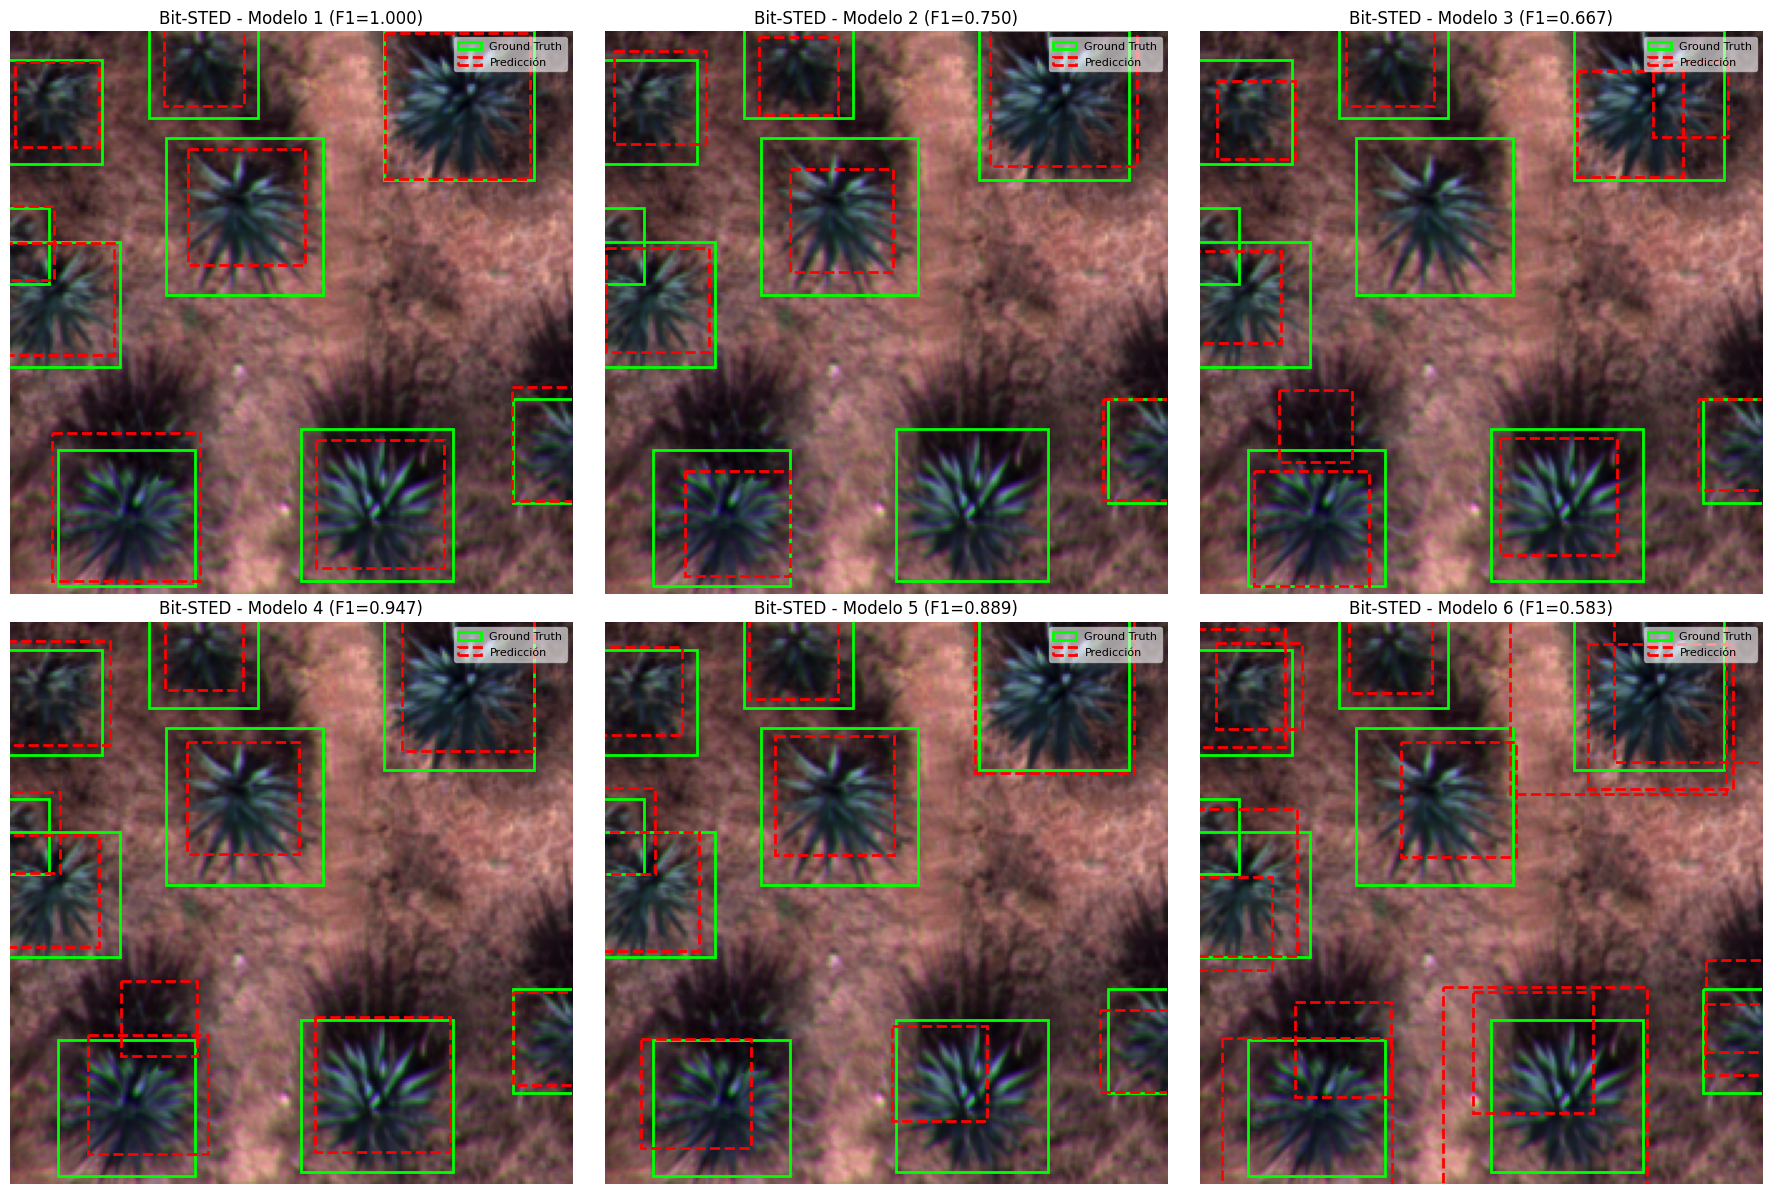

In [ ]:
# ============================================================
# Demostración de funcionamiento (6 modelos Bit-STED)
# ============================================================

# Crear figura con 6 subplots (2 filas x 3 columnas)
fig, ejes = plt.subplots(2, 3, figsize=(18, 12))
ejes = ejes.flatten()

# Títulos dinámicos para cada modelo
titulos = [f"Bit-STED - Modelo {i+1}" for i in range(len(resultados_models))]

# Dibujar resultados
for eje, (nombre, datos), titulo in zip(ejes,resultados_models .items(), titulos):
    imagen = datos["imagen"]
    gt_cajas = datos["gt"]
    pred_cajas = datos["pred"]
    f1 = datos["f1"]

    # Agregar F1 al título para comparación visual
    titulo_completo = f"{titulo} (F1={f1:.3f})"
    dibujar_resultados(imagen, gt_cajas, pred_cajas, titulo=titulo_completo, ax=eje)

plt.tight_layout()
plt.show()

In [ ]:

# Función para evaluar el modelo Bit-STED
def evaluar_modelo_bitsted(modelo, lista_imagenes, etiquetas_dir, iou_umbral=0.5, conf=0.4, diou=0.5):
    """
    Evalúa el modelo Bit-STED con preprocesamiento compatible:
    - Conversión BGR→RGB
    - Redimensionado a 224×224
    - Normalización explícita a [0, 1]
    """
    precisiones, recalls, f1s = [], [], []

    for img_path in lista_imagenes:
        nombre = Path(img_path).stem
        label_path = Path(etiquetas_dir) / f"{nombre}.txt"
        if not label_path.exists():
            continue

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            continue

        h, w = img_bgr.shape[:2]
        gt_cajas = leer_etiquetas_yolo(label_path, w, h)

        # Preprocesamiento
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb_224 = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_AREA)
        img_f32 = img_rgb_224.astype(np.float32) / 255.0
        imagen_tensor = torch.from_numpy(img_f32).permute(2, 0, 1).unsqueeze(0)

        # Inferencia Bit-STED
        with torch.no_grad():
            boxes_bit, scores_bit, _, _ = utils.counting.inference(
                modelo, imagen_tensor.to(device), 'cbbox',
                conf_thr=conf, diou_thr=diou
            )

        # Convertir círculos a cajas rectangulares
        if boxes_bit and len(boxes_bit[0]) > 0:
            boxes_bit_np = boxes_bit[0].cpu().numpy()
            pred_cajas = convertir_circulos_a_cajas(boxes_bit_np)
        else:
            pred_cajas = []

        # Calcular métricas
        p, r, f1 = calcular_metricas(gt_cajas, pred_cajas, iou_umbral)
        precisiones.append(p)
        recalls.append(r)
        f1s.append(f1)

    return np.mean(precisiones), np.mean(recalls), np.mean(f1s)

# Función para medir tiempo promedio de inferencia (ms)
def medir_tiempo_inferencia(modelo, img_path, tipo="yolo", n_iter=3):
    """
    Calcula el tiempo promedio de inferencia en milisegundos
    sobre una imagen de prueba, repitiendo la inferencia n_iter veces.
    """
    tiempos = []
    for _ in range(n_iter):
        inicio = time.time()

        if tipo == "yolo":
            _ = modelo.predict(source=img_path, imgsz=224, conf=0.25, verbose=False)
        else:
            img_bgr = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_rgb_224 = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_AREA)
            img_f32 = img_rgb_224.astype(np.float32) / 255.0
            img_tensor = torch.from_numpy(img_f32).permute(2, 0, 1).unsqueeze(0)

            _ = utils.counting.inference(modelo, img_tensor.to(device), 'cbbox', conf_thr=0.4, diou_thr=0.5)

        tiempos.append((time.time() - inicio) * 1000)

    return np.mean(tiempos)

In [ ]:
# Rutas y configuración
val_dir = Path("Zones_cbbox_dataset_10/val/images")
label_dir = Path("Zones_cbbox_dataset_10/val/labels_yolo")
val_images = sorted(val_dir.glob("*.png"))
img_ejemplo = str(random.choice(val_images)) if val_images else None

# Modelos Bit-STED a evaluar
modelos = {
    "Bit-STED (Modelo 1)": models_paths[0],
    "Bit-STED (Modelo 2)": models_paths[1],
    "Bit-STED (Modelo 3)": models_paths[2],
    "Bit-STED (Modelo 4)": models_paths[3],
    "Bit-STED (Modelo 5)": models_paths[4],
    "Bit-STED (Modelo 6)": models_paths[5]
}

# Evaluación de los modelos Bit-STED
resultados = []
device = torch.device("cpu")

for i, (nombre, ruta) in enumerate(modelos.items()):
    print(f"Evaluando modelo: {nombre}")

    # Cargar modelo Bit-STED
    modelo = TransformerObjectDetection(
        image_size=224,
        N_channels=3, 
        n_model=models_size[i],
        num_blks=models_blks[i],
        obj="cbbox",
        device=device,
        bitNet=True
    ).to(device)

    checkpoint = torch.load(ruta, map_location=device)
    modelo.load_state_dict(
        checkpoint["model"] if isinstance(checkpoint, dict) and "model" in checkpoint else checkpoint
    )
    modelo.eval()

    # Evaluar métricas y tiempos
    precision, recall, f1 = evaluar_modelo_bitsted(modelo, val_images, label_dir,conf=conf_thrs[i],diou=diou_thrs[i])
    tiempo_ms = medir_tiempo_inferencia(modelo, img_ejemplo, tipo="bitsted")
    peso_mb = os.path.getsize(ruta) / (1024 ** 2)

    resultados.append({
        "Modelo": nombre,
        "Precisión": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4),
        "Tiempo Promedio (ms)": round(tiempo_ms, 2),
        "Tamaño (MB)": round(peso_mb, 2)
    })

# Tabla comparativa de resultados
df_metricas = (
    pd.DataFrame(resultados)
    .sort_values("F1-Score", ascending=False)
    .reset_index(drop=True)
)

display(
    df_metricas.style
        .background_gradient(subset=["F1-Score"], cmap="Greens")
        .background_gradient(subset=["Tiempo Promedio (ms)"], cmap="Reds")
        .set_caption("Desempeño y eficiencia de los modelos Bit-STED en validación")
)

Evaluando modelo: Bit-STED (Modelo 1)
Evaluando modelo: Bit-STED (Modelo 2)
Evaluando modelo: Bit-STED (Modelo 3)
Evaluando modelo: Bit-STED (Modelo 4)
Evaluando modelo: Bit-STED (Modelo 5)
Evaluando modelo: Bit-STED (Modelo 6)


,Modelo,Precisión,Recall,F1-Score,Tiempo Promedio (ms),Tamaño (MB)
0,Bit-STED (Modelo 1),0.695500,0.909600,0.776200,30.610000,1.360000
1,Bit-STED (Modelo 4),0.442100,0.663600,0.519700,76.410000,4.070000
2,Bit-STED (Modelo 2),0.530500,0.483200,0.492100,37.780000,4.070000
3,Bit-STED (Modelo 6),0.390900,0.702300,0.490200,39.770000,1.370000
4,Bit-STED (Modelo 5),0.451400,0.565500,0.482300,485.960000,294.550000
5,Bit-STED (Modelo 3),0.340900,0.329900,0.327500,59.210000,1.770000


Procesando modelo 1/6: Bit-STED (Modelo 1) (models/best_finetuned.pt)
Procesando modelo 2/6: Bit-STED (Modelo 2) (models/modelbest_nano_300.pt)
Procesando modelo 3/6: Bit-STED (Modelo 3) (models/modelbest_hipernano.pt)
Procesando modelo 4/6: Bit-STED (Modelo 4) (models/modelbest_hiperparametros.pt)
Procesando modelo 5/6: Bit-STED (Modelo 5) (models/big_best.pt)
Procesando modelo 6/6: Bit-STED (Modelo 6) (models/best_finetuned_gradual.pt)


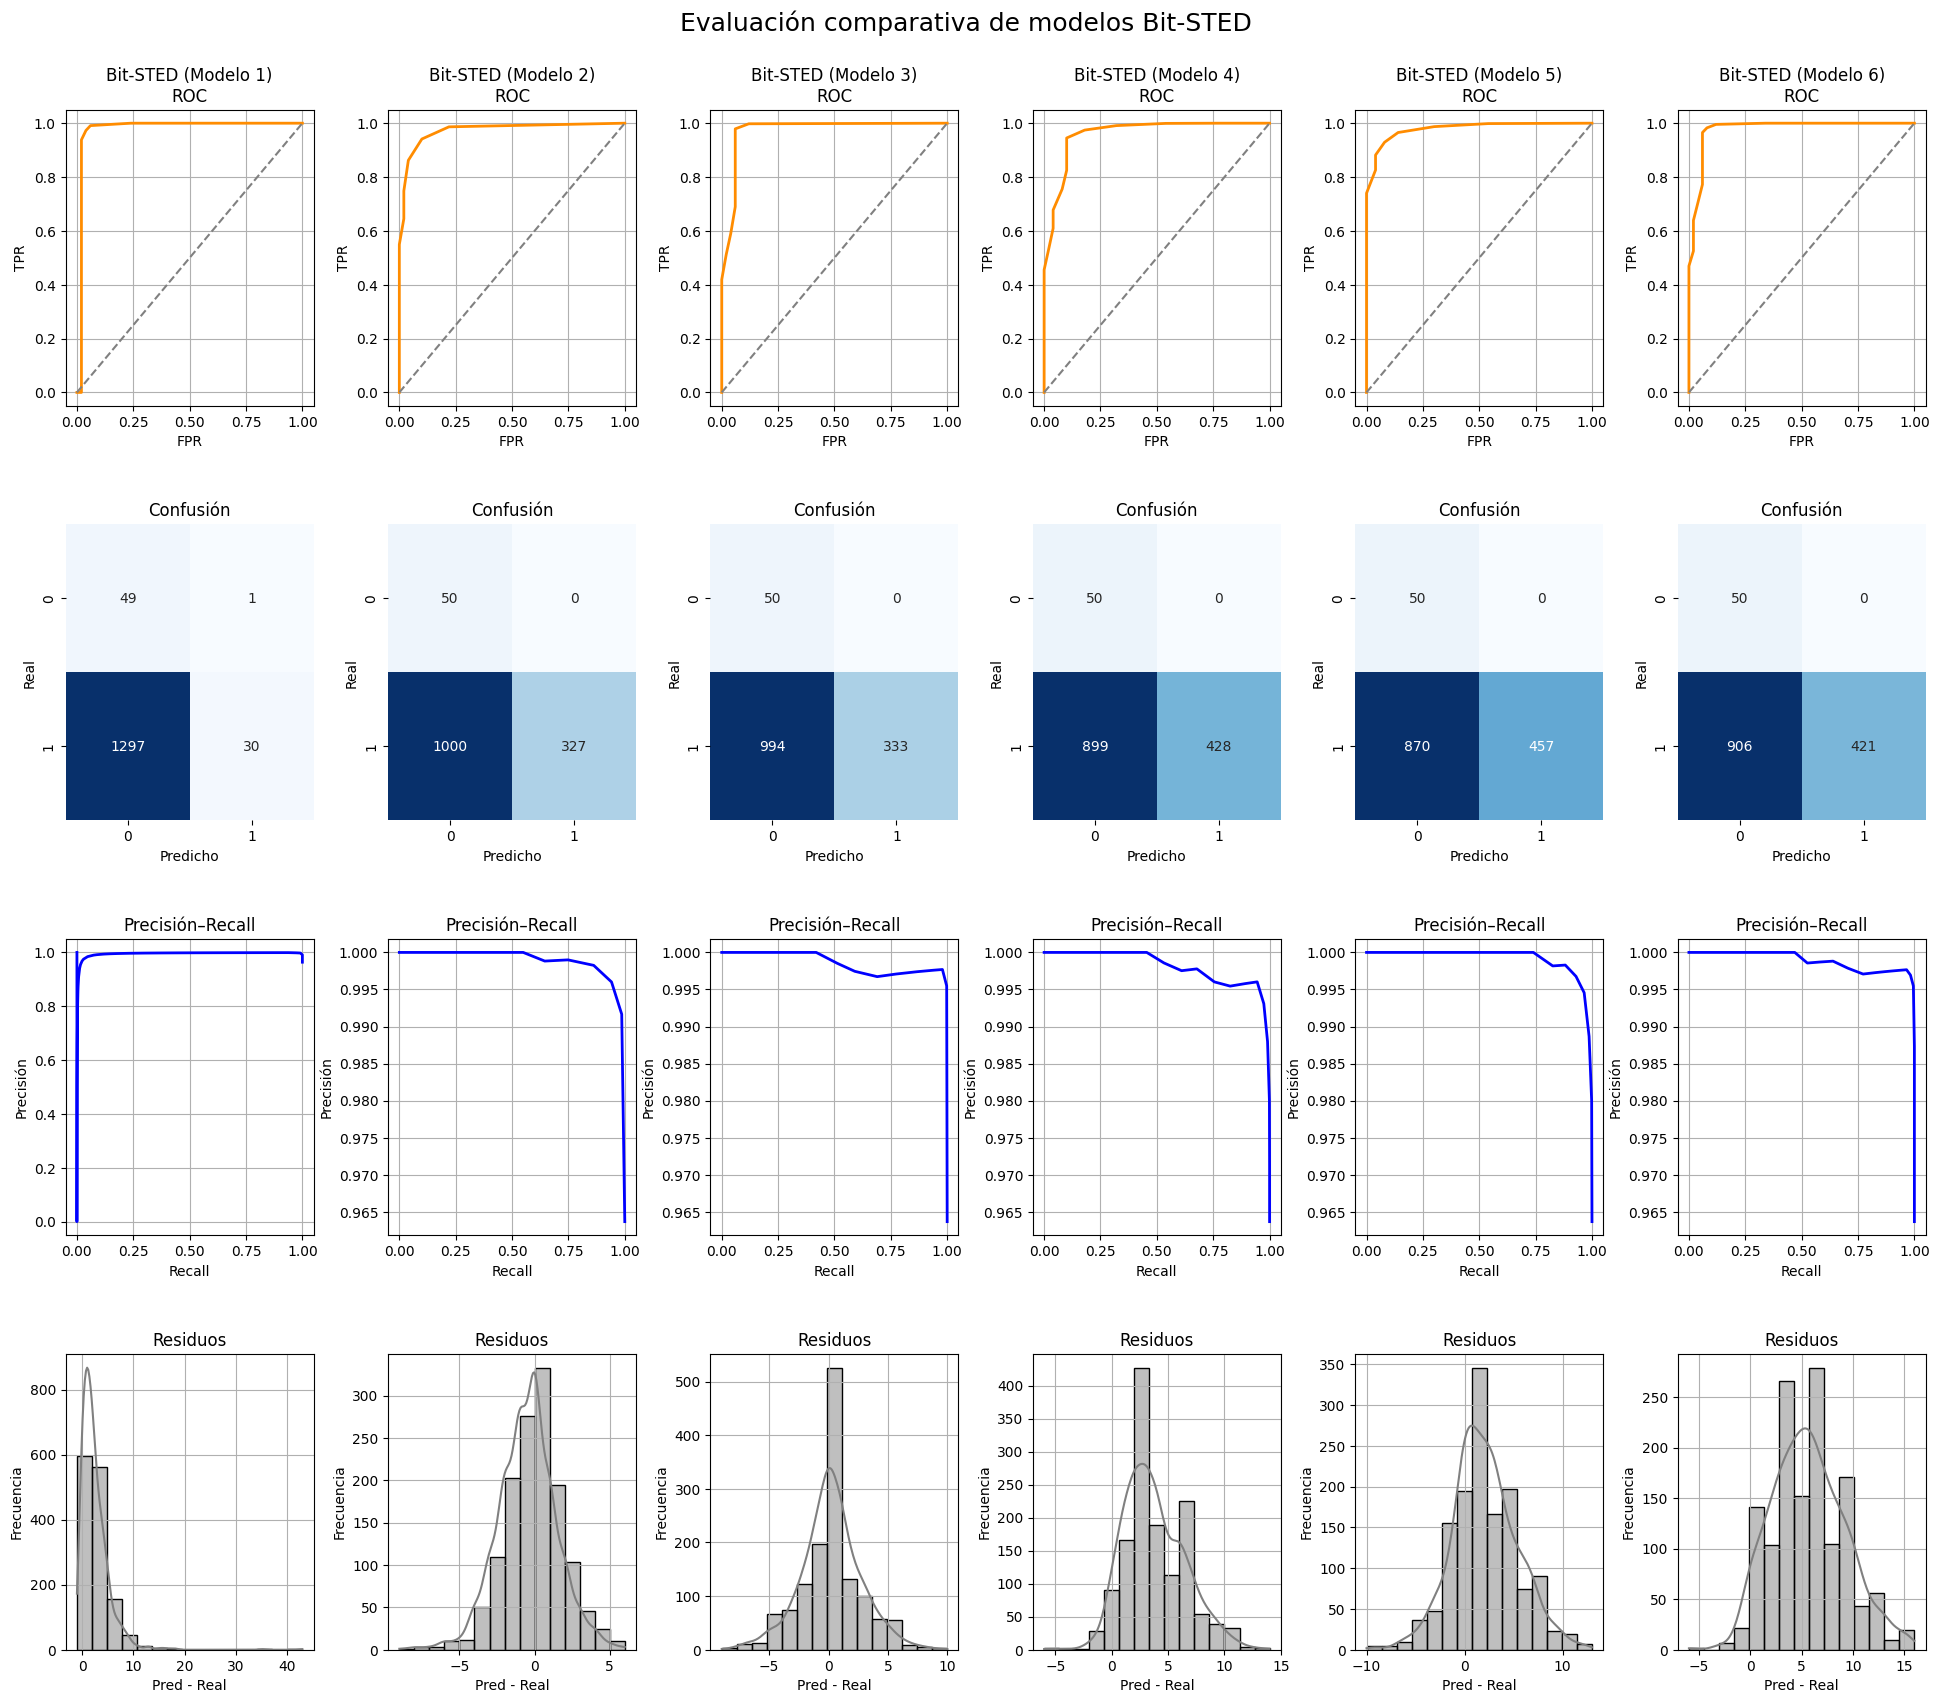

In [46]:
# Evaluación completa y visualización de los 6 modelos Bit-STED

# Configuración de figura
n_modelos = len(modelos)
fig, axes = plt.subplots(4, n_modelos, figsize=(4 * n_modelos, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Evaluar cada modelo sobre todas las imágenes de validación
for col, (nombre, model_path) in enumerate(modelos.items()):
    print(f"Procesando modelo {col+1}/{n_modelos}: {nombre} ({model_path})")

    y_true, y_score, residuos = [], [], []

    for img_path in val_images:
        nombre_img = Path(img_path).stem
        label_path = label_dir / f"{nombre_img}.txt"
        if not label_path.exists():
            continue

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            continue

        h, w = img_bgr.shape[:2]
        gt_cajas = leer_etiquetas_yolo(label_path, w, h)

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        pred_cajas = inferir_bit_sted(
            model_path=model_path,
            imagen=img_rgb,
            device='cpu',
            conf_thr=conf_thrs[col],
            diou_thr=diou_thrs[col],
            n_size=models_size[col],
            num_blks=models_blks[col]
        )

        y_true.append(1 if len(gt_cajas) > 0 else 0)
        y_score.append(len(pred_cajas))
        residuos.append(len(pred_cajas) - len(gt_cajas))

    y_true = np.array(y_true)
    y_score = np.array(y_score, dtype=float)
    if y_score.max() > 0:
        y_score /= y_score.max()

    # Curva ROC
    ax = axes[0, col]
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC={roc_auc:.2f}")
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_title(f"{nombre}\nROC")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.grid(True)

    # Matriz de confusión
    ax = axes[1, col]
    y_pred_bin = [1 if s > 0.5 else 0 for s in y_score]
    cm = confusion_matrix(y_true, y_pred_bin)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title("Confusión")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")

    # 3. Curva Precisión–Recall
    ax = axes[2, col]
    if len(np.unique(y_true)) > 1:
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        pr_auc = auc(recall, precision)
        ax.plot(recall, precision, color="blue", lw=2, label=f"AUC={pr_auc:.2f}")
    ax.set_title("Precisión–Recall")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precisión")
    ax.grid(True)

    # Análisis de residuos
    ax = axes[3, col]
    sns.histplot(residuos, kde=True, bins=15, color="gray", edgecolor="black", ax=ax)
    ax.set_title("Residuos")
    ax.set_xlabel("Pred - Real")
    ax.set_ylabel("Frecuencia")
    ax.grid(True)

plt.suptitle("Evaluación comparativa de modelos Bit-STED",
             fontsize=18, y=0.93)
plt.show()


# Conclusiones

Se evaluaron seis modelos principales del tipo Bit-STED con distintos ajustes de hiperparámetros, incluyendo variaciones en la cantidad de elementos, épocas de entrenamiento y parámetros de ajuste focal alfa y gamma. Estos cambios impactaron no solo en precisión, exactitud y F1, sino también en el número de parámetros y el peso del modelo, aspectos críticos para implementación en sistemas embebidos.

Los modelos modelbest_nano_300.pt y modelbest_hipernano.pt mostraron un buen equilibrio entre rendimiento y eficiencia, mientras que big_best.pt y best_finetuned_gradual.pt ofrecieron desempeño comparable con mayor complejidad y peso.

Se probaron además cinco variantes adicionales con distintos optimizadores, tasas de aprendizaje y schedulers (adam_lr_1e-4, adamw_scheduler, sgd_optimizer, entre otros), pero no se incluyeron en el análisis final debido a que sus métricas fueron significativamente bajas.

En conclusión, aunque el modelo nano otorgó el rendimiento más sólido, el modelo “hipernano” es una alternativa viable por su menor peso y menor tiempo de ejecución, manteniendo buena precisión y eficiencia para su aplicación futura.